---
topic: "Topic 6A: Machine Learning/AI"
subtitle: "UAS Image Classification"
title: "Assignment 6A"
original-assignment-due-date: 11/06/2024
assignment-due-date: 12/1/2025
author:
    - Corey White
date: 11/10/25
format: html
toc-depth: 4
activity: Assignment/Lab
keep-ipynb: true
notebook-view:
  - notebook: Assignment6A.ipynb
    title: "UAS Image Classification"
    url: https://colab.research.google.com/drive/1sia6F1oPW1ISV8a-6YkEEhJhXriVrYdG?usp=sharing
---

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1sia6F1oPW1ISV8a-6YkEEhJhXriVrYdG?usp=sharing)

## Outline

- Feature Engineering
- Segmentation
- Image Classification
- Validation

## Data

Download imagery data from March and June flights during 2017.

<!-- - [Orthos June 2017]({{< var data.lake_wheeler_flight_Jun_2017_orthos >}}) -->
- [Orthos July 2024]({{< var data.lake_wheeler_flight_July_17_2024_orthophoto >}})
- [DSM July 2024]({{< var data.lake_wheeler_flight_July_17_2024_dsm >}})

## Workflow

Create a new mapset within your `Lake_Wheeler_NCspm` project and set your working directory.

Import the ortho imagery for the July 17, 2024 UAS flight. The orthophoto is save as a [*Cloud Optimized GeoTIFF (COG)*](http://cogeo.org/) which allows us to directory import the data using r.import with needing to download the data beforehand.

```bash
r.import input=https://storage.googleapis.com/gis-course-data/gis584/uas-flight-data/Lake%20Wheeler%20-%20NCSU/071724/odm_orthophoto.tif resample=nearest output=odm_071724_ortho
```

Let's set the compuational region to the ortho imagery.

```bash
g.region raster=odm_071724_ortho.1
```

:::{.callout-important}
**Task:** What is the spatial resolution and how many pixels are include in the compuational region?
:::

<!-- ### Find overlaping areas

```bash
  r.series input="ortho_2017_06_02,ortho_2017_06_02" output="series_count" method=count
``` -->

<!-- :::{.callout-important}
**Task:** Create a raster mask using raster algebra (`r.mapcalc`) to generate a raster where if both rasters overlap set the new raster to equal `1` else `null`.
::: -->

<!-- ### Visual Change Detection

Map Swipe Tool `File -> Map Swipe` select your top left raster map and bottom/right raster map and press `OK`. Use the slider to examine the differences between to two dates. -->

<!-- :::{.callout-important}
**Task:** Describe the difference you see between the two dates.
::: -->

<!-- ### Binary Change Detection -->

<!-- ### Image differencing

```bash
r.mapcalc expression=rgb_diff = ortho_2017_03_29  -  ortho_2017_06_02
r.colors -e map=rgb_diff color=bcyr
``` -->

### Image Classification

Let's create an RGB color composite from our ortho bands.

```bash
r.composite -d red=odm_071724_ortho.1 green=odm_071724_ortho.2 blue=odm_071724_ortho.3 output=odm_071724_ortho.rgb
```

Let's create a raster mask for our analysis.

```bash
r.mapcalc expression="img_mask = if( odm_071724_ortho.rgb, 1, null())"
r.mask raster=img_mask
```

### Spectral Feature Extraction

#### Spectral Indices

Calculate `VARI (Visible Atmospherically Resistant Index)` index [Gitelson et al. (2002)](https://digitalcommons.unl.edu/cgi/viewcontent.cgi?article=1151&context=natrespapers).

```bash
r.mapcalc expression="vari_2024 = (odm_071724_ortho.2 - odm_071724_ortho.1) / (odm_071724_ortho.2 + odm_071724_ortho.1 - odm_071724_ortho.3)"
```

Let's look at the univariate statistics of our `vari_2024` raster.

```bash
r.univar vari_2024
```

:::{.callout-important}
**Task:** What is the range from the `vari_2024` univariate statistics?
:::

Now let's look at the metadata for each of our bands.

```bash
r.info odm_071724_ortho.1
r.info odm_071724_ortho.2
r.info odm_071724_ortho.3
```

Our original ortho bands were unsigned 8bit integers (a `CELL` data type in GRASS) ranging from 0-255 in value. However, when we calulate VARI the data is expected to be scaled from 0-1. To do this we must rescale our band data and cast our output data to Float32.

```bash
r.mapcalc expression="odm_071724_ortho.red = if(isnull(odm_071724_ortho.1), null(), float(odm_071724_ortho.1) / 255.0)"
r.mapcalc expression="odm_071724_ortho.green = if(isnull(odm_071724_ortho.2), null(), float(odm_071724_ortho.2) / 255.0)"
r.mapcalc expression="odm_071724_ortho.blue = if(isnull(odm_071724_ortho.3), null(), float(odm_071724_ortho.3) / 255.0)"
```

Now let's compute VARI for our dataset.

$$
VARI = \frac{(Green - Red)}{(Green + Red - Blue)}
$$

```bash
r.mapcalc --overwrite expression="odm_071724_ortho.vari = (odm_071724_ortho.green - odm_071724_ortho.red) / (odm_071724_ortho.green + odm_071724_ortho.red - odm_071724_ortho.blue)"

# Use the same color palette as NDVI
r.colors map=odm_071724_ortho.vari color=ndvi
```

Let's examine the univariate statistics.

```bash
r.univar odm_071724_ortho.vari
```

We can see that our `min`, `max`, and `variatoin coefficient` are quite extreme as we would expect the results to fall within the range -1.0 - 1.0.

This may be casued by outliers in our data where values in our denominator are zero or very close to zero. To fix this we can add a small constant to our denominator called `epsilon` to avoid an possible divison by zero errors.

```bash
r.mapcalc --overwrite expression="odm_071724_ortho.vari = (odm_071724_ortho.green - odm_071724_ortho.red) / (odm_071724_ortho.green + odm_071724_ortho.red - odm_071724_ortho.blue + 0.01)"

# Use the same color palette as NDVI
r.colors map=odm_071724_ortho.vari color=ndvi
```

Now let's recheck the univariate statistics.

```bash
r.univar odm_071724_ortho.vari
```

Although the `min`, `max`, and `variatoin coefficient` have improved they are still indicating outliers are skewing our data.

To address this create a mask for cells where the denominator is greater than 0.1. 

```bash
r.mapcalc --overwrite expression="vari_mask = if((odm_071724_ortho.green + odm_071724_ortho.red - odm_071724_ortho.blue) > 0.3, 1, null())"

r.mapcalc --overwrite expression="odm_071724_ortho.vari = if(vari_mask, (odm_071724_ortho.green - odm_071724_ortho.red) / (odm_071724_ortho.green + odm_071724_ortho.red - odm_071724_ortho.blue), null())"
```

Now examine the univariate statistics again.

```bash
r.univar odm_071724_ortho.vari
d.rast odm_071724_ortho.vari
d.rast vari_mask
```

:::{.callout-important}
**Task:** Examine areas that were excluded by the `vari_mask`. What type of things are responsible for the outliers? How else might you address these issues?
:::


![VARI Example](../images/lake_wheeler_vari.png){width=45%}

#### Low Pass Filters

We will now compute a *smooth* layer to remove noise from our data with the [r.neighbors](https://grass.osgeo.org/grass84/manuals/r.neighbors.html) tool. To do this we will compute the mean value for each pixel using a 27x27 moving window.

```bash
r.neighbors input=odm_071724_ortho.1 size=27 method=average output=odm_071724_ortho.1.27x27mean
```

![27x27 Moving Window Mean](../images/low_pass_filter_mean_moving_window_red.png){width=45%}

#### High Pass Filters

We will now create a layer to define our edges using the `zero-crossings` edge detection method implemented as [i.zc](https://grass.osgeo.org/grass-devel/manuals/i.zc.html) in GRASS. The output raster will contain cells (edges) labeled 0-4 which represent the azimuth directions (similar to aspect).

```bash
i.zc --overwrite input=odm_071724_ortho.2 output=odm_071724_ortho.2.zc orientations=4 threshold=0.5
```

![](../images/zero_crossing_4d.png){width=100%}

We can also use descriptive neighborhood statistics, such as, the standard deviation to calculate edges in our data.

```bash
r.neighbors -c input=odm_071724_ortho.2 size=7 method=stddev output=odm_071724_ortho.2.7x7stddev
```

![](../images/high_pass_filter_variance_moving_window_green.png){width=40%}
![](../images/high_pass_filter_variance_moving_window_green2.png){width=40%}

:::{.callout-important}
**Task:** Find a nice color scheme to display `odm_071724_ortho.2.7x7stddev` and describe what information can be derived from the map.
:::


#### Texture Features

Now we will calcuate the texture features Angular Second Moment (asm), Correlation (corr), and Contrast (con)
 for our green band using [r.texture](https://grass.osgeo.org/grass-devel/manuals/r.texture.html) which implements Haralick et al. (1973) Grey level co-occurrence matrix (GLCM).



```bash
r.texture odm_071724_ortho.2 output=odm_071724_ortho.green_texture method="asm,contrast,corr" -s
```

![Angular Second Moment](../images/glcm_asm45.png){width=25%}
![Correlation](../images/glcm_cor45.png){width=25%}
![Contrast](../images/glcm_contr45.png){width=25%}

### Topographic Features Extraction

Not all features need to come from spectal data! You can use data from the DSM to provide more data when training your classification model.

To start import the DSM data from the July, 2024 flight.

```bash
r.import resample=bilinear extent=region input=https://storage.googleapis.com/gis-course-data/gis584/uas-flight-data/Lake%20Wheeler%20-%20NCSU/071724/dsm.tif output=odm_071724_dsm

# (Optional) Set the color table and create a relief map for viusalization
r.colors map=odm_071724_dsm color=elevation
r.relief input=odm_071724_dsm output=dsm_relief
```

#### Slope and Aspect

Calculate slope and aspect using [r.slope.aspect](https://grass.osgeo.org/grass-devel/manuals/r.slope.aspect.html)

```bash
r.slope.aspect elevation=odm_071724_dsm slope=odm_071724_slope aspect=odm_071724_aspect pcurvature=odm_071724_pcurv tcurvature=odm_071724_tcurv
```

#### Terrain Forms

Now derive terrain forms form the the DSM using [r.geomorphon](https://grass.osgeo.org/grass-devel/manuals/r.geomorphon.html).

```bash
r.geomorphon elevation=odm_071724_dsm forms=geomorphon search=3 skip=0 flat=1 dist=0
```

### Create Imagery Group

GRASS uses imagery groups ([i.group](https://grass.osgeo.org/grass84/manuals/i.group.html)) to manage imagery data.

Let's start by creating a new imagery group called `rgb_group` with the subgroup `rgb_group` and add the red, green, and blue bands to the group/subgroup.

```bash
i.group group=rgb_group subgroup=rgb_group input=odm_071724_ortho.1,odm_071724_ortho.2,odm_071724_ortho.3
```

You can now check that it worked by viewing which rasters are in the group (`rgb_group`) and subgroup (`rgb_group`).

```bash
i.group -l group=rgb_group subgroup=rgb_group
```

Let's now add some of our other derived features to the group (`analysis_bands`) in a new subgroup called `analysis_bands`.

```bash
i.group group=analysis_bands subgroup=analysis_bands input=odm_071724_ortho.vari,odm_071724_ortho.3,odm_071724_ortho.1.27x27mean,odm_071724_dsm,odm_071724_slope,odm_071724_aspect,odm_071724_pcurv,odm_071724_tcurv,geomorphon,odm_071724_ortho.2.7x7stddev
```

### Image Segmentation

Install [i.superpixels.slic](https://grass.osgeo.org/grass-devel/manuals/addons/i.superpixels.slic.html) GRASS Addon using the `g.extension` command.

```bash
g.extension i.superpixels.slic
```

Let's see if we can segment the fields.

```bash
# Reduce the compuational region
g.region n=219508.87 s=219309.09 w=636953.87 e=637210.35 res=0.07 -ap
i.superpixels.slic input=analysis_bands output=superpixels num_pixels=200
```

Let's see if we can improve our segmentation to capture individual crops in the field.

```bash
i.superpixels.slic input=analysis_bands output=superpixels_analysis compactness=0.8 num_pixels=100000
```

For our object based classification we will use [i.segment.stats](https://grass.osgeo.org/grass-devel/manuals/addons/i.segment.stats.html) to generate multiple statistics about our segments at once.

To do this we must first install [i.segment.stats](https://grass.osgeo.org/grass-devel/manuals/addons/i.segment.stats.html).

```bash
g.extension i.segment.stats
```

Compute the mean, standard deviation, and sum for each feature per segment. We also compute details about the geomertry of each segment such as the area, perimeter, and compactness.   

:::{.callout-caution}
If you run this command as givin it will take a long time to run. Try to reduce the number of segments to speed things up.
:::

```bash
i.segment.stats map=superpixels rasters=odm_071724_ortho.1,odm_071724_ortho.2,odm_071724_ortho.3 raster_statistics="mean,stddev,sum" vectormap=segment_stats processes=3
```
### Classification

For classification we are going to use a decision tree based model called a RandomForest. To do this we need to install the GRASS addon [r.learn.ml](https://grass.osgeo.org/grass-devel/manuals/addons/r.learn.ml.html) which gives us access to models from the [scikit learn](https://scikit-learn.org/stable/) python library.

```bash
g.extension extension=r.learn.ml2
```

#### Sampling

One benifit of using the RandomForest classification model is that it utilizes a sampling strategy know as *bootstraping*. It does this by using out-of-bag samples (OOB) for each decision tree in the model. The OOB samples are used to calculate error, which works as a cross-validation mechanism and helps maintain diversity between decision trees.  

However, many models require you to sample your data independently. To do this you can perform and random sample using [r.random](https://grass.osgeo.org/grass-devel/manuals/r.random.html) or a stratified random sample using [r.sample.category](https://grass.osgeo.org/grass84/manuals/addons/r.sample.category.html).

Let's import NLCD 2019 land cover data to perform the sampling.

:::{.callout-caution}
When importing COGs make sure to set the `extent=region` to make sure you are only downloading the data you need.
:::

```bash
r.import input=https://storage.googleapis.com/stac-data/Spatial_Data/LandUse/NLCD_Land_Cover_L48/nlcd_2019_cog/nlcd_2019_cog.tif output=nlcd_2019 extent=region resolution=region resample=nearest
```

Now we will perform a stratified random sample using [r.sample.category](https://grass.osgeo.org/grass84/manuals/addons/r.sample.category.html).

However, we must first install the addon:

```bash
g.extension r.sample.category
```

Now run the command to take 1000 samples from each land cover class.

```bash
r.category map=nlcd_2019
r.sample.category input=nlcd_2019 output=nlcd_2019_strat_samples npoints=1000
# Display the sample data
d.rast nlcd_2019
d.vect nlcd_2019_strat_samples
```

:::{.callout-important}
**Task:** How many NLCD classes were sampled? Would these training points work well for classifying our dataset?
:::

#### Train Model

To train the model you will use [r.learn.train](https://grass.osgeo.org/grass-devel/manuals/addons/r.learn.train.html). The random forest model requires us to provide a [training_map](resources/training.gpkg) and our imagery group. To save time use our `rgb_group`, but in practice you should using the `analysis_bands` group that contains the additional features you created.

Training data can be downloaded here: [Download Training Data](resources/training.gpkg) or you can create your own using the `g.gui.iclass` tool found at `Imagery -> Classify image -> Interactive input for supervised classification`.

To use the downloaded training data you need to fisrt import `training.gpkg` into GRASS.

```bash
v.import input=training.gpkg layer=training output=training
```

The training module [r.learn.train](https://grass.osgeo.org/grass-devel/manuals/addons/r.learn.train.html) expects the `training_map` parameter to be a raster, so you need to convert the training data to raster where the raster values matches each categories class.

```bash
v.to.rast input=training output=training_rf use=attr attribute_column=cat_ label_column=class
```

:::{.callout-warning}
Model training can take a long time to run. If you are having issues running on your local machine try shrinking the compuational region.
:::

```bash
r.learn.train group=rgb_group training_map=training_rf model_name=RandomForestClassifier n_estimators=500 save_model=rf_model.gz max_features=3 fimp_file=feature_importance.csv -f
```

The trained model will be save as `rf_model.gz`.

#### Feature Importance

You can calculate the feature importance by using the `-f` flag and saving the results to a csv file using the parameter `fimp_file`. Our feature importance is saved to `feature_importance.csv`.

The features with higher the importance scores indicate they are more influential in making predictions. While features with  low importance, could potentially be removed to simplify the model.

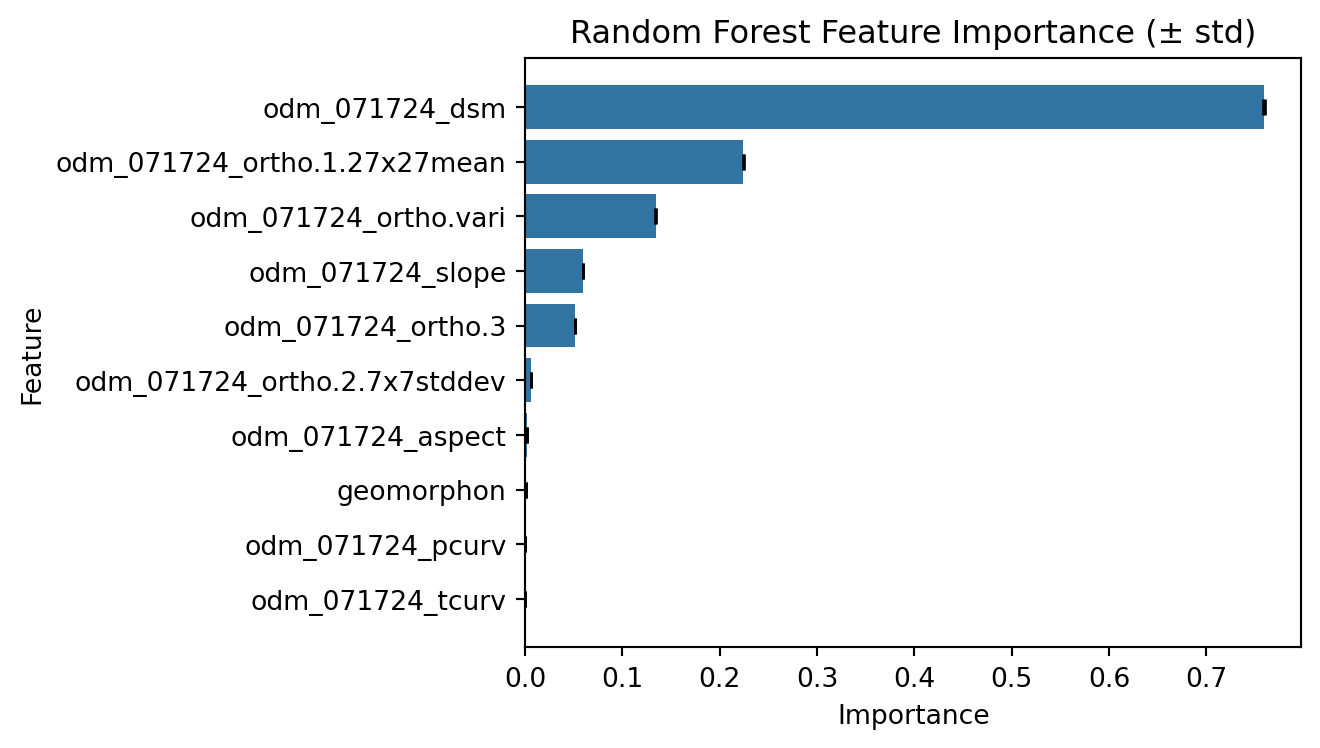

In [1]:
# Feature importance plot (requires pandas, seaborn, matplotlib)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fi = pd.read_csv("feature_importance_rf.csv")
fi = fi.sort_values("importance", ascending=False)

plt.figure(figsize=(7, 4))
sns.barplot(
    data=fi, x="importance", y="feature", orient="h", errorbar=None
)  # std provided separately
# Add error bars manually
for i, (imp, std) in enumerate(zip(fi["importance"], fi["std"])):
    plt.errorbar(
        x=imp, y=i, xerr=std, fmt="none", ecolor="black", capsize=3, linewidth=0.8
    )

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance (± std)")
plt.tight_layout()
plt.savefig("../images/feature_importance_rf.png")

#### Run Model

To use the model run [r.learn.predict](https://grass.osgeo.org/grass-devel/manuals/addons/r.learn.predict.html) by loading the model ([`rf_model.gz`](https://storage.googleapis.com/gis-course-data/gis584/uas-flight-data/Lake%20Wheeler%20-%20NCSU/071724/rf_model.gz)) you create during training.

```bash
r.learn.predict group=rgb_group load_model=rf_model.gz output=rf_basic_classification
```

Now we can check the categories and set the colors.

You can download the color table here [category_colors.txt](resources/category_colors.txt) or copy the rules here

```bash
1 255:0:0
2 0:128:0
3 255:255:0
4 139:105:20
5 127:127:127
6 128:0:128
7 144:238:144
8 165:42:42
9 255:165:0
nv white
```

```bash
# check raster categories - they are automatically applied to the classification output
r.category rf_classification
r.colors map=rf_basic_classification rules=category_colors.txt
```
![](../images/basic_classification.png)

#### Model Validation

We will now evaluate our model by looking at the models confussion matrix, overvall accuracy, and kappa coefficient using the GRASS addon [r.confusionmatrix](https://grass.osgeo.org/grass84/manuals/addons/r.confusionmatrix.html).

To begin we first need to install the addon.

```bash
g.extension r.confusionmatrix
```

Now run [r.confusionmatrix](https://grass.osgeo.org/grass84/manuals/addons/r.confusionmatrix.html)  

```bash
r.confusionmatrix classification=rf_basic_classification raster_reference=training_rf -m -d
```

The output for our classified model will look similar to below

**Overall accuracy**

Number of correct pixels / total number of pixels

`Overall Accuracy, 97.07`


**User Accuracy**

* From the perspective of the user of the classified map, how accurate is the map?
* For a given class, how many of the pixels on the map are actually what they say they are?
* Calculated as: Number correctly identified in a given map class / Number claimed to be in that map class

**Producer Accuracy**

* From the perspective of the maker of the classified map, how accurate is the map?
* For a given class in reference plots, how many of the pixels on the map are labeled correctly?
* Calculated as: Number correctly identified in ref. plots of a given class / Number actually in that reference class

**Commission Error**

Commission error refers to sites that are classified as to reference sites that were left out (or omitted) from the correct class in the classified map. Commission errors are calculated by reviewing the classified sites for incorrect classifications.

Commission Error = 100 % - User Accuracy

**Omission Error**

Omission error refers to reference sites that were left out (or omitted) from the correct class in the classified map. The real land cover type was left out or omitted from the classified map.

Omission Error = 100 % - Producer Accuracy

**Kappa coefficient**

It characterizes the degree of matching between reference data set and classification.

- **Kappa = 0**: indicates that obtained agreement equals chance agreement.
- **Kappa > 0**: indicates that obtained agreement is greater than chance agreement.
- **Kappa < 0**: indicates that obtained agreement is smaller than chance agreement.
- **Kappa = 1**: is perfect agreement.

`Kappa coefficient, 0.85`

:::{.callout-important}
**Task:** Interpret how well the model is performing. Which classes are performing well? Which need to be improved?
:::

|       Category         | buildings            | trees               | fields               | ground               | road               | car               | crop               |  	farm equipment               | bale               | User Accuracy   | Commission Error |
|----------------|---------------|-----------------|-----------------|----------------|---------------|-----------------|-----------------|---------------|-----------------|-----------------|
|   buildings     | 80379           | 63              | 22              | 6               | 70              | 27              | 1               | 34              | 24              | 99.69           | 0.31            |
|   trees         | 118             | 264667          | 25671           | 0               | 237             | 2               | 105             | 44              | 0               | 91.0            | 9.0             |
|                 fields        | 610             | 77160           | 6187667         | 16564           | 53766           | 268             | 762             | 2636            | 133             | 97.6            | 2.4             |
|                 ground        | 57              | 1               | 8871            | 45799           | 3132            | 1               | 2               | 151             | 0               | 78.94           | 21.06           |
|                 road          | 409             | 58              | 7070            | 1559            | 221794          | 1709            | 1               | 395             | 77              | 95.16           | 4.84            |
|                 car           | 75              | 2               | 38              | 0               | 2694            | 19216           | 0               | 18              | 1095            | 83.05           | 16.95           |
|                 crop          | 0               | 1               | 2               | 0               | 2               | 0               | 36              | 0               | 0               | 87.8            | 12.2            |
|                 farm equipment| 32              | 9               | 88              | 5               | 46              | 19              | 0               | 4311            | 1               | 95.57           | 4.43            |
|                 bale          | 20              | 0               | 2               | 0               | 5               | 2               | 0               | 1               | 719             | 95.99           | 4.01            |
|                 Producer Accuracy | 98.38       | 77.4            | 99.33           | 71.64           | 78.72           | 90.45           | 3.97            | 56.8            | 35.09                   |

<!-- ## Optional

### LLM-based image segmentation with SAMGeo2

```bash
g.extension r.confusionmatrix
``` -->